In [4]:
import numpy as np
import pandas as pd


import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn, optim

from torchvision import transforms, models
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.io import loadmat
from PIL import Image
from tqdm import tqdm

import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
print(os.listdir())
path_devkit = 'devkit/'
path_train_img = 'cars_train/'
path_test_img = 'cars_test/'

NUM_CLASSES = 196
IMG_SIZE = 224
RANDOM_SEED = 42

['.git', 'utils.py', '__pycache__', 'classifier.ipynb', 'cars_train.tgz', 'cars_train', 'test.ipynb', 'tmux-server-3267.log', 'cars_test.tgz', '.gitignore', '.ipynb_checkpoints', 'tmux-client-3265.log', 'devkit', 'checkpoint_epoch_20.pth', 'cars_test']


In [6]:
# lets store the information in the dataframe
mat = loadmat(path_devkit+'cars_meta.mat')

classes = []
for C in mat['class_names'][0]:
    classes.append(C[0])
classes = pd.DataFrame(classes,columns=['class_name'])

#blankidx = [''] * len(classes)
#classes.index = blankidx
classes.head()

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [9]:
# lets store the data in the dataFrame
mat = loadmat(path_devkit+'cars_train_annos.mat')
train_df = []
for row in mat['annotations'][0]:
    train_df.append([row[0][0][0],    # min x
                     row[1][0][0],    # max x
                     row[2][0][0],    # min y
                     row[3][0][0],    # max y
                     row[4][0][0],    # class
                     row[5][0]])   # file name


train_df = pd.DataFrame(train_df, columns=['min_x', 'min_y', 'max_x', 'max_y','class_name', 'file_name'])
train_df.head()

,min_x,min_y,max_x,max_y,class_name,file_name
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [10]:
# lets store the test data in the dataFrame
mat = loadmat(path_devkit+'cars_test_annos.mat')
test_df = []
for row in mat['annotations'][0]:
    test_df.append([row[0][0][0],    # min x
                    row[1][0][0],    # max x
                    row[2][0][0],    # min y
                    row[3][0][0],    # max y
                    row[4][0][0]])   # file name

test_df = pd.DataFrame(test_df, columns=['min_x', 'min_y', 'max_x', 'max_y', 'file_name'])
test_df.head()

,min_x,min_y,max_x,max_y,file_name
0,30,52,246,147,0
1,100,19,576,203,0
2,51,105,968,659,0
3,67,84,581,407,0
4,140,151,593,339,0


In [11]:
# now split the train dataset into val and train
val_df = train_df.sample(frac=0.2, random_state=RANDOM_SEED)
train_df = train_df.drop(val_df.index)

print('Training set: {}\nValidation set: {}'.format(train_df.shape, val_df.shape))

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Training set: (6515, 6)
Validation set: (1629, 6)


class_name    Audi TTS Coupe 2012
Name: 13, dtype: object


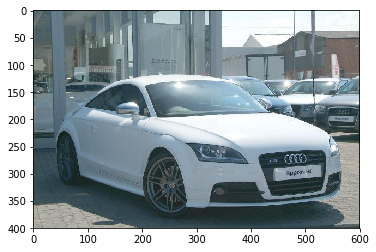

In [12]:
img = plt.imread(path_train_img+'00001.jpg')
plt.imshow(img)
print(classes.iloc[13])

## **EDA**
Lets check data distribution

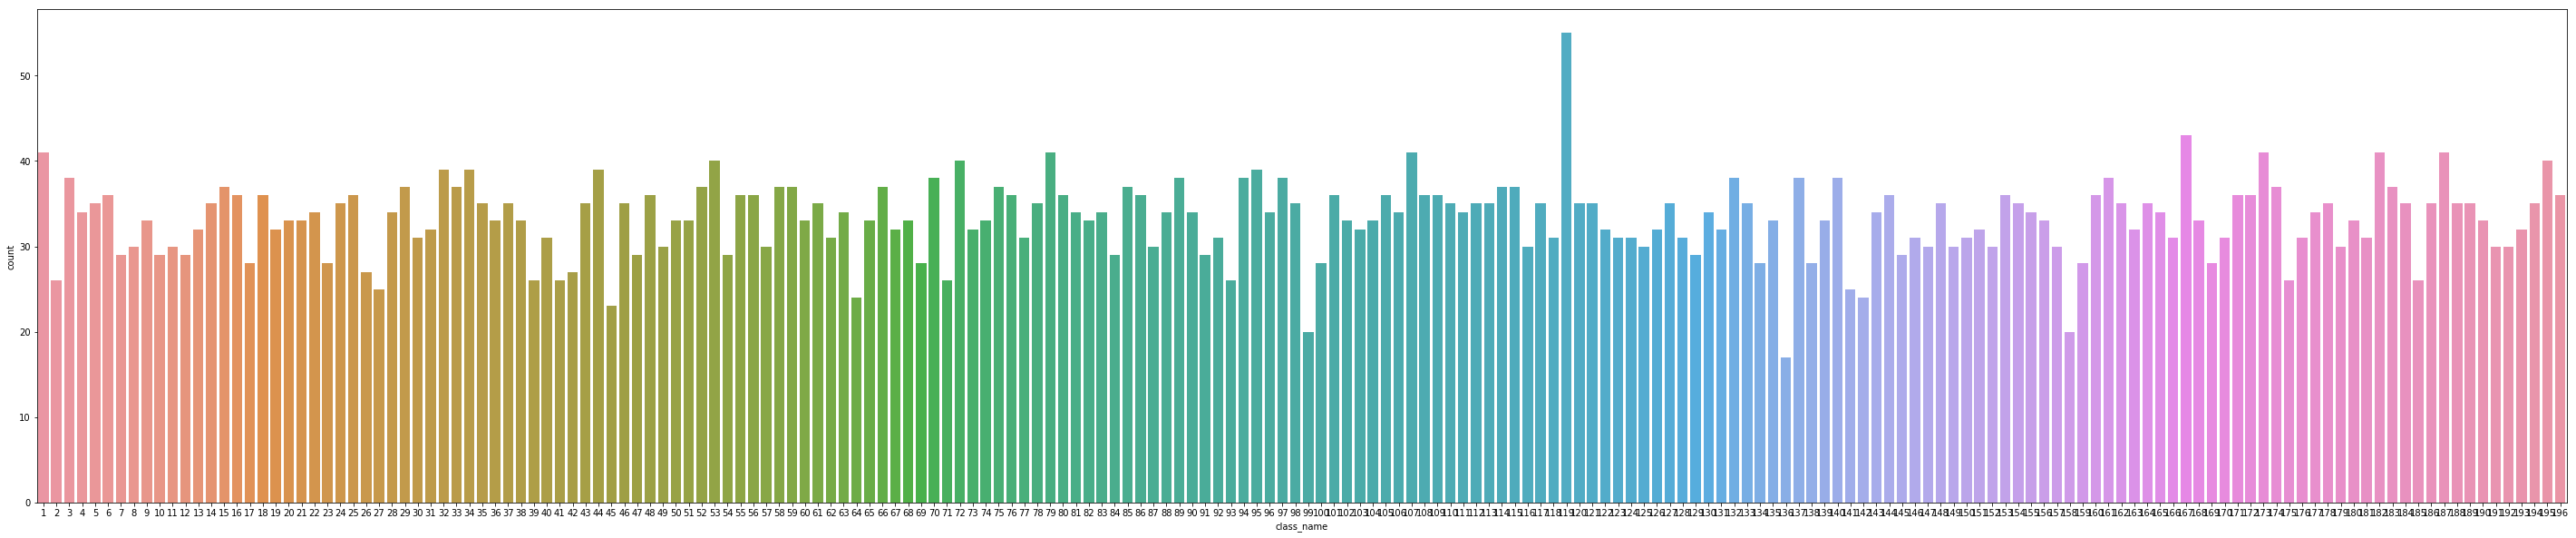

In [13]:
plt.subplots(figsize=(50,10))
ax = sns.countplot(x='class_name', data=train_df)

In [14]:
class_count_sorted = train_df.class_name.value_counts(ascending=True)
print('class {} has min samples i.e. {}'.format(class_count_sorted.index[0], class_count_sorted.iloc[0]))
print('class {} has max samples i.e. {}'.format(class_count_sorted.index[-1], class_count_sorted.iloc[-1]))

class 136 has min samples i.e. 17
class 119 has max samples i.e. 55


In [15]:
print(class_count_sorted.describe())

count    196.000000
mean      33.239796
std        4.489149
min       17.000000
25%       31.000000
50%       34.000000
75%       36.000000
max       55.000000
Name: class_name, dtype: float64


So it is evident that the each class of the dataset has somewhat similar number of training samples and the distribution in balanced.<br>
Therefore, **accuracy** would be perfect metric to measure the performance of the model.

In [16]:
# print(train_df.info())
# types={'min_x':np.int16, 'min_y':np.int16, 'max_x':np.int16, 'max_y':np.int16,'class_name':np.int8}
# train_df = train_df.astype(types)
# print(train_df.info())

In [25]:
class CarDataset(Dataset):
    def __init__(self,df, classes, path_img, transforms=None, mode='train'):
        self.df = df
        self.classes = classes
        self.path_img = path_img
        self.transforms = transforms
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df.iloc[index]['file_name']
        img = Image.open(self.path_img+img_name).convert('RGB')   # to create images with 3 channels
        # create one hot vector for the label
        label = None
        #crop image
        img = img.crop((self.df.iloc[index]['min_x'],
                        self.df.iloc[index]['min_y'],
                        self.df.iloc[index]['max_x'],
                        self.df.iloc[index]['max_y']))
        
        if self.mode == 'train':
            #label[self.df.iloc[index]['class_name'] - 1] = 1    
            label = self.df.iloc[index]['class_name']-1
            
        if self.mode == 'test':
            # do nothing, more specifically we do not need to create
            None 
        
        if self.transforms is not None:
            img =  self.transforms(img)
            
            return img, label

## **Training segment**

In [19]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])


train_dataset = CarDataset(train_df, classes, path_train_img, transforms = transform_train)
train_generator = DataLoader(train_dataset, batch_size=32, shuffle=True)

# validation data generator
val_dataset = CarDataset(val_df, classes, path_train_img, transforms = transform_train, mode='train')
val_generator = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [20]:
images, labels = next(iter(train_generator))
print('Image shape: {}\nLabels shape: {}'.format(images.shape, labels.shape))

Image shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 905.5, -0.5)

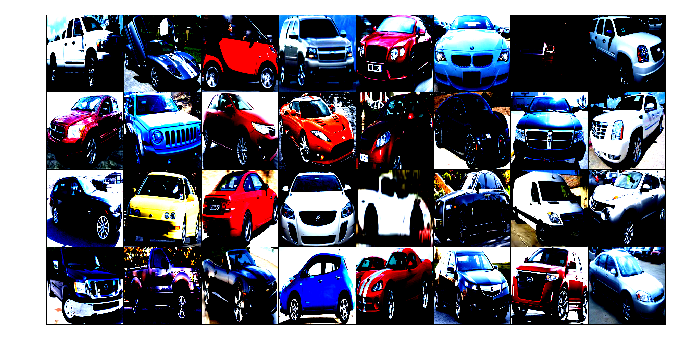

In [21]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
grid = make_grid(images,nrow=8)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
#plt.title(labels)

In [22]:
# network
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1024,NUM_CLASSES),
                                 nn.Softmax(dim=1))      # need to change this to softmax as we also need to predict the confidence score.


# class customDensenet121(nn.Module):
#     def __init__(self,num_classes):
#         super(customDensenet121,self).__init__()
#         self.features = nn.Sequential(*list(model.features.children()))
#         self.classifier = nn.Sequential(nn.Linear(1024,num_classes),
#                                         nn.Sigmoid())
        
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0),-1)
#         x = self.classifier(x)
#         return x

/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/dungeon_master/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:35<00:00, 913398.89it/s] 


In [23]:
# helper functions
def accuracy(y, pred_y, dim=1):
    #_, y_index = torch.max(y, dim=dim)
    y_index = y
    _, pred_y_index = torch.max(pred_y, dim=dim,)
    num_correct = torch.sum(pred_y_index==y_index)
    acc = num_correct.item()/len(y)
    return acc

def precision(y, pred_y, dim=1):
    _, y_index = torch.max(y, dim=dim)
    _, pred_y_index = torch.max(pred_y, dim=dim)
    precision = precision_score(y_index.numpy(), pred_y_index.numpy(), average='micro')
    return precision

def recall(y, pred_y, dim=1):
    _, y_index = torch.max(y, dim=dim)
    _, pred_y_index = torch.max(pred_y, dim=dim)
    recall = recall_score(y_index.numpy(), pred_y_index.numpy(),average='micro')
    return recall
    

In [24]:
use_gpu = False

if torch.cuda.is_available:
    model.cuda()
    use_gpu = True

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def train_model(model, epochs, train_generator, val_generator, use_gpu, optimizer, criterion):
    train_loss, val_loss = [],[]
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_generator:
            if use_gpu:
                labels = labels.cuda()
                labels = labels.type(torch.cuda.LongTensor)
                #labels = labels.type(torch.cuda.FloatTensor)
                images = images.cuda()
            
            optimizer.zero_grad()
            ps = model(images)
            #print(ps.shape, labels.shape)
            loss = criterion(ps,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        else:
            acc = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in val_generator:
                    if use_gpu:
                        images = images.cuda()
                        labels = labels.cuda()
                        labels = labels.type(torch.cuda.LongTensor)
                        #labels = labels.type(torch.cuda.FloatTensor)
                        
                    ps = model(images)
                    test_loss += criterion(ps, labels)
                    #print(ps, labels)
                    acc += accuracy(labels, ps)
        
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), 'checkpoint_epoch_{}.pth'.format(epoch+1))
            
        train_loss.append(running_loss/len(train_generator))
        val_loss.append(test_loss/len(val_generator))
        val_acc.append(acc/len(val_generator))
        model.train()
        
        print('Epoch: {}/{}'.format(epoch+1,epochs),
              'Training Loss: {}\t\tValidation Loss: {}'.format(train_loss[-1], val_loss[-1]),
              'Val Accuracy:  {}'.format(val_acc[-1]),sep='\n')
    
    return train_loss,val_loss,val_acc

In [ ]:
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([{'params': model.features.parameters()},
                     {'params': model.classifier.parameters(), 'lr': 0.001}],
                    lr=0.0001)

train_losses, val_losses, val_acc = train_model(model,epochs,train_generator, val_generator, 
                                       use_gpu, optimizer, criterion)

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
plt.plot(val_acc, label='Val Accuracy')
plt.legend(frameon=False)